# Für alle Frames und mit Plotten 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
# Konfiguration der Dateipfade und Marker
def make_config(person, trial):
    config = {
        'vicon_file_path': f'E:/Datenerhebung MA/Vicon_csv/mittelwert/{person}/60fps/{trial}_mittelwert_60fps.csv',
        'poseformer_file_paths': {
              'cam1': f'E:/Datenerhebung MA/PoseFormerV2 Daten/{person}/Cam1/{trial}_1/pose3D_keypoints/combined/combined_keypoints.npz',
                'cam2': f'E:/Datenerhebung MA/PoseFormerV2 Daten/{person}/Cam2_hoch/{trial}_2_hoch/pose3D_keypoints/combined/combined_keypoints.npz',
                'cam3': f'E:/Datenerhebung MA/PoseFormerV2 Daten/{person}/Cam3/{trial}_3/pose3D_keypoints/combined/combined_keypoints.npz'
            },
       'mediapipe_0_file_path': {
                'cam1': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam1/Complexity0/{trial}_1_comp0.csv',
                'cam2': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam2/Complexity0/{trial}_2_comp0.csv',
                'cam3': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam3/Complexity0/{trial}_3_comp0.csv'
            },
        'mediapipe_1_file_path': {
                'cam1': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam1/Complexity1/{trial}_1_comp1.csv',
                'cam2': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam2/Complexity1/{trial}_2_comp1.csv',
                'cam3': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam3/Complexity1/{trial}_3_comp1.csv'
            },
        'mediapipe_2_file_path': {
                'cam1': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam1/Complexity2/{trial}_1_comp2.csv',
                'cam2': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam2/Complexity2/{trial}_2_comp2.csv',
                'cam3': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam3/Complexity2/{trial}_3_comp2.csv'
            },
        
        # Gelenkpunkte für die drei Systeme
        'joints': {
            'shoulder': {
                'vicon': ['RHIP', 'RSHO', 'LSHO', 'RELB'],  # Vicon-Marker für rechte Hüfte, rechte Schulter, linke Schulter, rechter Ellenbogen
                'poseformer': [1, 14, 11, 15],  # Poseformer-Indizes für rechte Hüfte, rechte Schulter, linke Schulter, rechter Ellenbogen
                'mediapipe': [24, 12, 11, 14]   # Mediapipe-Indizes für rechte Hüfte, rechte Schulter, linke Schulter, rechter Ellenbogen
            }
        }
    }
    return config

In [3]:
def extract_vicon_joint_positions(vicon_file_path, joint_names):
    data = pd.read_csv(vicon_file_path)
    
    joint_coords = []
    for joint in joint_names:
        joint_position = data[[f'{joint}:X', f'{joint}:Y', f'{joint}:Z']].values
        joint_coords.append(joint_position)
    
    return joint_coords

def extract_poseformer_joint_positions(poseformer_file_path, joint_indices):
    data = np.load(poseformer_file_path)

    # Initialisiere eine liste für die Koordinaten
    joint_coords = []

    # Iteriere durch die Frames
    for index in joint_indices:
        frames = []
        for key in data.files:
            frame = data[key]
            frames.append(frame[index])

        frames = np.array(frames)
        joint_coords.append(frames)
        
    return joint_coords

def extract_mediapipe_joint_positions(mediapipe_file_path, joint_indices):
    data = pd.read_csv(mediapipe_file_path)
    
    joint_coords = []
    for joint in joint_indices:
        joint_position = data[data['landmark_index'] == joint][['x', 'y', 'z']].values
        joint_coords.append(joint_position)
    
    return joint_coords

In [4]:
def extract_joint_coords(config, model, cam):

    if model == 'vicon':
        # Vicon-Daten extrahieren
        joint_coordinates = extract_vicon_joint_positions(config['vicon_file_path'], config['joints']['shoulder']['vicon'])

    elif model == 'poseformer':
        # Poseformer-Daten für cam extrahieren
        joint_coordinates = extract_poseformer_joint_positions(config['poseformer_file_paths'][cam], config['joints']['shoulder']['poseformer'])

    # Mediapipe-Daten extrahieren
    elif model == 'mediapipe_0':
        joint_coordinates = extract_mediapipe_joint_positions(config['mediapipe_0_file_path'][cam], config['joints']['shoulder']['mediapipe'])
    elif model == 'mediapipe_1':
        joint_coordinates = extract_mediapipe_joint_positions(config['mediapipe_1_file_path'][cam], config['joints']['shoulder']['mediapipe'])
    elif model == 'mediapipe_2':
        joint_coordinates = extract_mediapipe_joint_positions(config['mediapipe_2_file_path'][cam], config['joints']['shoulder']['mediapipe'])

    else:
        raise ValueError(f"Invalid model {model}")

    return joint_coordinates


In [5]:
def calculate_frontal_plane(right_shoulder, left_shoulder, right_hip):
    # Vektor von linker zu rechter Schulter
    shoulder_axis = right_shoulder - left_shoulder
    
    # Vektor von Hüftmittelpunkt zu rechter Schulter
    hip_to_shoulder = right_shoulder - right_hip
    
    # Normale zur Frontalebene (durch Kreuzprodukt)
    frontal_plane_normal = np.cross(shoulder_axis, hip_to_shoulder)
    
    # Normiere die Normale, um sie zu einer Einheit zu machen
    frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)

    return frontal_plane_normal
    
def calculate_sagittal_plane(frontal_plane_normal, right_shoulder, left_shoulder):
    # Vektor zwischen den Schultern (Schulterachse)
    shoulder_axis = right_shoulder - left_shoulder
    
    # Berechne den Vektor in der Frontalebene, der senkrecht zur Schulterachse steht
    # Das ist das Kreuzprodukt zwischen der Frontalebenen-Normale und der Schulterachse
    vector_perpendicular_to_shoulders = np.cross(frontal_plane_normal, shoulder_axis)
    
    # Normiere diesen Vektor
    vector_perpendicular_to_shoulders /= np.linalg.norm(vector_perpendicular_to_shoulders)
    
    # Die Sagittalebenen-Normale ist das Kreuzprodukt zwischen der Frontalebenen-Normale und dem Vektor, der senkrecht zur Schulterachse ist
    sagittal_plane_normal = np.cross(frontal_plane_normal, vector_perpendicular_to_shoulders)
    
    # Normiere die Sagittalebenen-Normale
    sagittal_plane_normal /= np.linalg.norm(sagittal_plane_normal)
    
    return sagittal_plane_normal


# Funktion zur Projektion eines Vektors auf eine Ebene
def project_vector_onto_plane(vector, plane_normal):
    # Berechne die Projektion des Vektors auf die Ebene, indem der Anteil entlang der Ebenennormalen entfernt wird
    vector_projection = vector - np.dot(vector, plane_normal) * plane_normal
    return vector_projection

# Funktion zur Berechnung des Winkels zwischen zwei Vektoren
def calculate_angle_between_vectors(v1, v2):
    # Normiere beide Vektoren
    v1_normalized = v1 / np.linalg.norm(v1)
    v2_normalized = v2 / np.linalg.norm(v2)
    
    # Berechne das Skalarprodukt
    dot_product = np.dot(v1_normalized, v2_normalized)
    
    # Berechne den Winkel in Grad
    angle = np.degrees(np.arccos(np.clip(dot_product, -1.0, 1.0)))
    
    return angle



# Funktion zur Bestimmung von Flexion oder Extension und Anpassung des Vorzeichens
def adjust_flexion_extension_sign(upper_arm_vector, frontal_plane_normal, angle):
    # Berechne das Skalarprodukt des Oberarmvektors mit der Normale der Frontalebene
    direction_sign = np.dot(upper_arm_vector, frontal_plane_normal)

    
    if direction_sign > 0: # Extension = arm hinter dem rücken
        if angle < 180:  
            # Winkel zwischen 0 und -90 Grad. 
            return -angle
        else:
            # -90 bis -180 Grad sind anatomisch nicht möglich / unwahrscheinlich. dann eher 180 - 270 Grad verwenden
            return 360 - angle
    
    else:  # Flexion
        return angle



# Funktion zur Berechnung der Flexions-/Extensions- und Abduktions-/Adduktionswinkel
def calculate_shoulder_angles(shoulder, elbow, hip, frontal_plane_normal, sagittal_plane_normal, direction):
    # Berechne den Oberarmvektor (Schulter zu Ellenbogen)
    upper_arm_vector = elbow - shoulder
    # Projiziere den Oberarmvektor auf die Sagittalebene (für Flexion/Extension)
    upper_arm_sagittal_proj = project_vector_onto_plane(upper_arm_vector, sagittal_plane_normal)
    
    # Berechne den Vektor von der Schulter zur Hüfte
    hip_to_shoulder = hip - shoulder
    

    # Projiziere den Schulter-Hüfte-Vektor auf die Frontalebene
    hip_to_shoulder_frontal_proj = project_vector_onto_plane(hip_to_shoulder, frontal_plane_normal)
    assert all(hip_to_shoulder_frontal_proj - hip_to_shoulder < 1e-5), f"Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: {hip_to_shoulder}, projiziert: {hip_to_shoulder_frontal_proj}"
    
    # Projiziere den Schulter-Hüfte-Vektor auf die Sagittalebene
    hip_to_shoulder_sagittal_proj = project_vector_onto_plane(hip_to_shoulder, sagittal_plane_normal)

    if direction == 'flexion_extension':
        # Berechne den Flexions-/Extensionswinkel (zwischen den beiden Sagittalprojektionen)
        flexion_extension_angle = calculate_angle_between_vectors(upper_arm_sagittal_proj, hip_to_shoulder_sagittal_proj)

        # Flexion oder Extension basierend auf Vorzeichen anpassen
        flexion_extension_angle = adjust_flexion_extension_sign(elbow - shoulder, frontal_plane_normal, flexion_extension_angle)

        angle = flexion_extension_angle

    elif direction == 'abduction_adduction':
        # Projiziere den Oberarmvektor auf die Frontalebene (für Abduktion/Adduktion)
        upper_arm_frontal_proj = project_vector_onto_plane(upper_arm_vector, frontal_plane_normal)

        # Berechne den Abduktions-/Adduktionswinkel (zwischen der Frontalprojektion und dem Hüft-Schulter-Vektor)
        abduction_adduction_angle = calculate_angle_between_vectors(upper_arm_frontal_proj, hip_to_shoulder_frontal_proj)
     # Abduktion oder adduktion basierend auf Vorzeichen anpassen
       # abduction_adduction_angle = adjust_abduction_adduction_sign(elbow - shoulder, sagittal_plane_normal, abduction_adduction_angle)
        
        angle = abduction_adduction_angle

    else: 
        raise ValueError(f"Invalid direction: {direction}")

    return angle
    




In [6]:
##stimmt noch nicht


def adjust_abduction_adduction_sign(upper_arm_vector, sagittal_plane_normal, angle):
    # Berechne das Skalarprodukt des Oberarmvektors mit der Normale der Frontalebene
    direction_sign = np.dot(upper_arm_vector, sagittal_plane_normal)

    
    if direction_sign > 0: # Adduktion = arm näher am Körper als in Neutralposition
        if angle < 90:  
            # Winkel zwischen 0 und -90 Grad. 
            return -angle
        else:
            # -90 bis -180 Grad sind anatomisch nicht möglich / unwahrscheinlich. dann eher 180 - 270 Grad verwenden
            return 360 - angle
    
    else:  # Flexion
        return angle

In [7]:



def get_angles_for_model_and_cam(config, model, cam, direction):
    # direction ist entweder 'flexion_extension' oder 'abduction_adduction'
    
    # Listen zur Speicherung der berechneten Winkel (je nach direction entweder flexion_extension oder abduction_adduction Winkel)
    shoulder_angles = []

    joint_coords = extract_joint_coords(config, model, cam)
    num_frames = len(joint_coords[0])  # 0 is the first joint in the config list, i.e. 'RHIP'

    for frame in range(num_frames):  
        #  order in config: ['RHIP', 'RSHO', 'LSHO', 'RELB']
        right_shoulder = joint_coords[1][frame]
        left_shoulder = joint_coords[2][frame]
        right_elbow = joint_coords[3][frame]
        right_hip = joint_coords[0][frame]
    
        # Berechne Frontal- und Sagittalebene
        frontal_plane_normal = calculate_frontal_plane(right_shoulder, left_shoulder, right_hip)
        sagittal_plane_normal = calculate_sagittal_plane(frontal_plane_normal, right_shoulder, left_shoulder)
    
        # Berechne die Winkel
        shoulder_angle = calculate_shoulder_angles(
            right_shoulder, right_elbow, right_hip, 
            frontal_plane_normal, sagittal_plane_normal,
            direction
        )
        
        # Speichern der Winkel
        shoulder_angles.append(shoulder_angle)

    return shoulder_angles


def get_angles(config, model, direction):
    # get angles for reference + model in all cams
    vicon_angles = get_angles_for_model_and_cam(config, 'vicon', None, direction)  # cam ist hier None, weil für Vicon ist das egal (wird ignoriert)
    model_cam1_angles = get_angles_for_model_and_cam(config, model, 'cam1', direction)
    model_cam2_angles = get_angles_for_model_and_cam(config, model, 'cam2', direction)
    model_cam3_angles = get_angles_for_model_and_cam(config, model, 'cam3', direction)

    return vicon_angles, model_cam1_angles, model_cam2_angles, model_cam3_angles

    

In [8]:
def calculate_angle_differences(vicon_angles, model_angles):
     # Sicherstellen, dass alle Arrays die gleiche Länge haben
    min_length = min(len(vicon_angles), len(model_angles))
        
    # Arrays auf gleiche Länge trimmen
    vicon_angles = np.array(vicon_angles[:min_length])
    model_angles = np.array(model_angles[:min_length])
    # Berechnung der Differenzen
    diff = model_angles - vicon_angles    

    return diff


def get_differences(vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3):
    diff_cam1 = calculate_angle_differences(vicon_angles, model_angles_cam1)
    diff_cam2 = calculate_angle_differences(vicon_angles, model_angles_cam2)
    diff_cam3 = calculate_angle_differences(vicon_angles, model_angles_cam3)

    return diff_cam1, diff_cam2, diff_cam3

### Plot functions

In [9]:


def plot_angles(config, trial, person, direction):
    # direction ist entweder 'flexion_extension' oder 'abduction_adduction'

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))
    fig.suptitle(f"Gelenkwinkel Vergleich ({trial}, {person}, {direction})")
    
    models = ["poseformer", "mediapipe_0", "mediapipe_1", "mediapipe_2"]
    
    for model, axis in zip(models, [ax1, ax2, ax3, ax4]):
        try:
            vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3 = get_angles(config, model, direction)
        except Exception as error:
            print(f"An exception occurred in {trial} {person} {direction} {model}", error) # An exception occurred: division by zero
            continue

            
        start_frame = 500
        end_frame = 2000

        # Plot für Vicon
        axis.plot(vicon_angles, label='Vicon', color='blue', linewidth=1)
        axis.plot(model_angles_cam1, label=f'Cam 1', color='green', linestyle='--')
        axis.plot(model_angles_cam2, label=f'Cam 2', color='orange', linestyle='--')
        axis.plot(model_angles_cam3, label=f'Cam 3', color='red', linestyle='--')
        axis.set_xlim((start_frame, end_frame))
        axis.set_ylim((-100, 250))
        
        # Titel, Labels und Legende
        axis.set_title(model)
        axis.set_xlabel('Frame')
        axis.set_ylabel('Winkel (Grad)')
        axis.legend()
        axis.grid(True)

        #break

    plt.tight_layout()
    #plt.savefig(f"E:/Datenerhebung MA/Plots & Auswertung/shoulder_{direction}/angles/{person}_{trial}.png")
    plt.show()
    plt.close()
    



In [10]:


def plot_differences_scatter(config, trial, person, direction):
    # direction ist entweder 'flexion_extension' oder 'abduction_adduction'
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))
    fig.suptitle(f"Gelenkwinkel Unterschied ({trial}, {person}, {direction})")
    
    models = ["poseformer", "mediapipe_0", "mediapipe_1", "mediapipe_2"]
    
    for model, axis in zip(models, [ax1, ax2, ax3, ax4]):
        try:
            vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3 = get_angles(config, model, direction)
        except Exception as error:
            print(f"An exception occurred in plot_differences_scatter {trial} {person} {direction} {model}", error)
            continue

        diff_cam1, diff_cam2, diff_cam3 = get_differences(vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3)

        start_frame = 500
        end_frame = 2000

     
        #axis.plot(diff_cam1, label=f'Cam 1', color='green', linestyle='--')
        axis.scatter(vicon_angles[start_frame:end_frame], diff_cam1[start_frame:end_frame], alpha=0.2, label="Cam1 Differenz", s=3, color = 'green')
        #axis.plot(diff_cam2, label=f'Cam 2', color='orange', linestyle='--')
        axis.scatter(vicon_angles[start_frame:end_frame], diff_cam2[start_frame:end_frame], alpha=0.2, label="Cam2 Differenz", s=3, color='orange')
        #axis.plot(diff_cam3, label=f'Cam 3', color='red', linestyle='--')
        axis.scatter(vicon_angles[start_frame:end_frame], diff_cam3[start_frame:end_frame], alpha=0.2, label="Cam3 Differenz", s=3, color='red')
        #axis.set_xlim((start_frame, end_frame))
        axis.set_ylim((-100, 100))
        # Titel, Labels und Legende
        axis.set_title(f"{model} frame: {start_frame} - {end_frame}")
        axis.set_xlabel('Vicon Gelenkwinkel')
        axis.set_ylabel('Model-Vicon Differenz (Grad)')
        axis.legend()
        axis.grid(True)

    plt.tight_layout()
    #plt.savefig(f"E:/Datenerhebung MA/Plots & Auswertung/shoulder_{direction}/angle_differences_scatter/{person}_{trial}.png")
    plt.show()
    plt.close()
    



In [11]:


def plot_differences_scatter_newaxis (config, trial, person, direction):
    # direction ist entweder 'flexion_extension' oder 'abduction_adduction'
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))
    fig.suptitle(f"Gelenkwinkel Unterschied ({trial}, {person}, {direction})")
    
    models = ["poseformer", "mediapipe_0", "mediapipe_1", "mediapipe_2"]
    
    for model, axis in zip(models, [ax1, ax2, ax3, ax4]):
        try:
            vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3 = get_angles(config, model, direction)
        except Exception as error:
            print(f"An exception occurred in plot_differences_scatter {trial} {person} {direction} {model}", error)
            continue

        diff_cam1, diff_cam2, diff_cam3 = get_differences(vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3)

        start_frame = 500
        end_frame = 2000

     
        #axis.plot(diff_cam1, label=f'Cam 1', color='green', linestyle='--')
        axis.scatter(model_angles_cam1[start_frame:end_frame], diff_cam1[start_frame:end_frame], alpha=0.2, label="Cam1 Differenz", s=3, color = 'green')
        #axis.plot(diff_cam2, label=f'Cam 2', color='orange', linestyle='--')
        axis.scatter(model_angles_cam2[start_frame:end_frame], diff_cam2[start_frame:end_frame], alpha=0.2, label="Cam2 Differenz", s=3, color='orange')
        #axis.plot(diff_cam3, label=f'Cam 3', color='red', linestyle='--')
        axis.scatter(model_angles_cam3[start_frame:end_frame], diff_cam3[start_frame:end_frame], alpha=0.2, label="Cam3 Differenz", s=3, color='red')
        #axis.set_xlim((start_frame, end_frame))
        axis.set_ylim((-100, 100))
        # Titel, Labels und Legende
        axis.set_title(f"{model} frame: {start_frame} - {end_frame}")
        axis.set_xlabel(f'{model} Gelenkwinkel')
        axis.set_ylabel('Model-Vicon Differenz (Grad)')
        axis.legend()
        axis.grid(True)

    plt.tight_layout()
    plt.savefig(f"E:/Datenerhebung MA/Plots & Auswertung/shoulder_{direction}/angle_differences_scatter_newaxis/{person}_{trial}.png")
   # plt.show()
    plt.close()
    


In [ ]:

def plot_correlation (config, trial, person, direction):
    # direction ist entweder 'flexion_extension' oder 'abduction_adduction'
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))
    fig.suptitle(f"Gelenkwinkel Unterschied ({trial}, {person}, {direction})")
    
    models = ["poseformer", "mediapipe_0", "mediapipe_1", "mediapipe_2"]
    
    for model, axis in zip(models, [ax1, ax2, ax3, ax4]):
        try:
            vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3 = get_angles(config, model, direction)
        except Exception as error:
            print(f"An exception occurred in plot_differences_scatter {trial} {person} {direction} {model}", error)
            continue

        diff_cam1, diff_cam2, diff_cam3 = get_differences(vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3)

        start_frame = 500
        end_frame = 2000

     
        #axis.plot(diff_cam1, label=f'Cam 1', color='green', linestyle='--')
        axis.scatter(model_angles_cam1[start_frame:end_frame], vicon_angles[start_frame:end_frame], alpha=0.2, label="Cam1", s=3, color = 'green')
        #axis.plot(diff_cam2, label=f'Cam 2', color='orange', linestyle='--')
        axis.scatter(model_angles_cam2[start_frame:end_frame], vicon_angles[start_frame:end_frame], alpha=0.2, label="Cam2", s=3, color='orange')
        #axis.plot(diff_cam3, label=f'Cam 3', color='red', linestyle='--')
        axis.scatter(model_angles_cam3[start_frame:end_frame], vicon_angles[start_frame:end_frame], alpha=0.2, label="Cam3", s=3, color='red')
        axis.set_xlim((-40, 2000))
        axis.set_ylim((-40, 200))
         # Hinzufügen der Linie y=x
        axis.plot([-40, 200], -[40, 200], color='black', linestyle='--', linewidth=1, label="y=x Linie")
        # Titel, Labels und Legende
        axis.set_title(f"{model} frame: {start_frame} - {end_frame}")
        axis.set_xlabel(f'{model} Gelenkwinkel')
        axis.set_ylabel('Vicon-Winkel (Grad)')
        axis.legend()
        axis.grid(True)

    plt.tight_layout()
    plt.savefig(f"E:/Datenerhebung MA/Plots & Auswertung/shoulder_{direction}/angle_correlation/{person}_{trial}.png")
   # plt.show()
    plt.close()
    

### Loop durch alle Personen und Trails: Plotte die Angles und Fehler

Plotting for AEN262 and 01_squat...
An exception occurred in 01_squat AEN262 flexion_extension x and y must be the same size
Plotting for AEN262 and 02_squat...
Plotting for AEN262 and 05_torso...
Plotting for AEN262 and 06_torso...
Plotting for AEN262 and 09_ebs...
Plotting for AEN262 and 10_ebs...
Plotting for AEN262 and 13_step...
Plotting for AEN262 and 14_step...
Plotting for AEN262 and 17_tubes...
Plotting for AEN262 and 18_tubes...
Plotting for AEN262 and 21_sprint...
Plotting for AEN262 and 22_sprint...
Plotting for DMN261 and 01_squat...
Plotting for DMN261 and 02_squat...
Plotting for DMN261 and 05_torso...
Plotting for DMN261 and 06_torso...
Plotting for DMN261 and 09_ebs...
Plotting for DMN261 and 10_ebs...
Plotting for DMN261 and 13_step...
Plotting for DMN261 and 14_step...
Plotting for DMN261 and 17_tubes...
Plotting for DMN261 and 18_tubes...
Plotting for DMN261 and 21_sprint...
Plotting for DMN261 and 22_sprint...
Plotting for MUN261 and 01_step...
Plotting for MUN261 

C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 02_squat NSN261 flexion_extension mediapipe_0 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 02_squat NSN261 flexion_extension mediapipe_1 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 02_squat NSN261 flexion_extension mediapipe_2 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]
Plotting for NSN261 and 05_torso...


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 05_torso NSN261 flexion_extension mediapipe_0 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 05_torso NSN261 flexion_extension mediapipe_1 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 05_torso NSN261 flexion_extension mediapipe_2 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]
Plotting for NSN261 and 06_torso...


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 06_torso NSN261 flexion_extension mediapipe_0 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 06_torso NSN261 flexion_extension mediapipe_1 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 06_torso NSN261 flexion_extension mediapipe_2 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]
Plotting for NSN261 and 09_ebs...


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 09_ebs NSN261 flexion_extension mediapipe_0 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]
Plotting for NSN261 and 10_ebs...


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 10_ebs NSN261 flexion_extension mediapipe_0 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 10_ebs NSN261 flexion_extension mediapipe_1 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 10_ebs NSN261 flexion_extension mediapipe_2 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]
Plotting for NSN261 and 13_step...


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 13_step NSN261 flexion_extension mediapipe_0 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 13_step NSN261 flexion_extension mediapipe_1 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 13_step NSN261 flexion_extension mediapipe_2 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]
Plotting for NSN261 and 14_step...


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 14_step NSN261 flexion_extension mediapipe_0 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]
Plotting for NSN261 and 17_tubes...


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 17_tubes NSN261 flexion_extension mediapipe_0 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 17_tubes NSN261 flexion_extension mediapipe_1 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 17_tubes NSN261 flexion_extension mediapipe_2 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]
Plotting for NSN261 and 18_tubes...
Plotting for NSN261 and 21_sprint...
Plotting for NSN261 and 22_sprint...


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 22_sprint NSN261 flexion_extension mediapipe_0 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 22_sprint NSN261 flexion_extension mediapipe_1 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]


C:\Users\localtest\AppData\Local\Temp\ipykernel_3744\2509524060.py:12: RuntimeWarning: invalid value encountered in divide
  frontal_plane_normal /= np.linalg.norm(frontal_plane_normal)


An exception occurred in plot_differences_scatter 22_sprint NSN261 flexion_extension mediapipe_2 Projizierter Schulter-Hüfte-Vektor auf Frontalebene ist nicht gleich wie original: original: [0. 0. 0.], projiziert: [nan nan nan]
Plotting for JKN261 and 01_step...
Plotting for JKN261 and 02_step...
Plotting for JKN261 and 05_squat...
Plotting for JKN261 and 06_squat...
Plotting for JKN261 and 09_ebs...
Plotting for JKN261 and 10_ebs...
Plotting for JKN261 and 13_tubes...
Plotting for JKN261 and 14_tubes...
Plotting for JKN261 and 17_sprint...
Plotting for JKN261 and 18_sprint...
Plotting for JKN261 and 21_torso...
Plotting for JKN261 and 22_torso...
Plotting for MAN262 and 01_step...
Plotting for MAN262 and 02_step...
Plotting for MAN262 and 05_squat...
Plotting for MAN262 and 06_squat...
Plotting for MAN262 and 09_ebs...
Plotting for MAN262 and 10_ebs...
Plotting for MAN262 and 13_tubes...
Plotting for MAN262 and 14_tubes...
Plotting for MAN262 and 17_sprint...
Plotting for MAN262 and 1

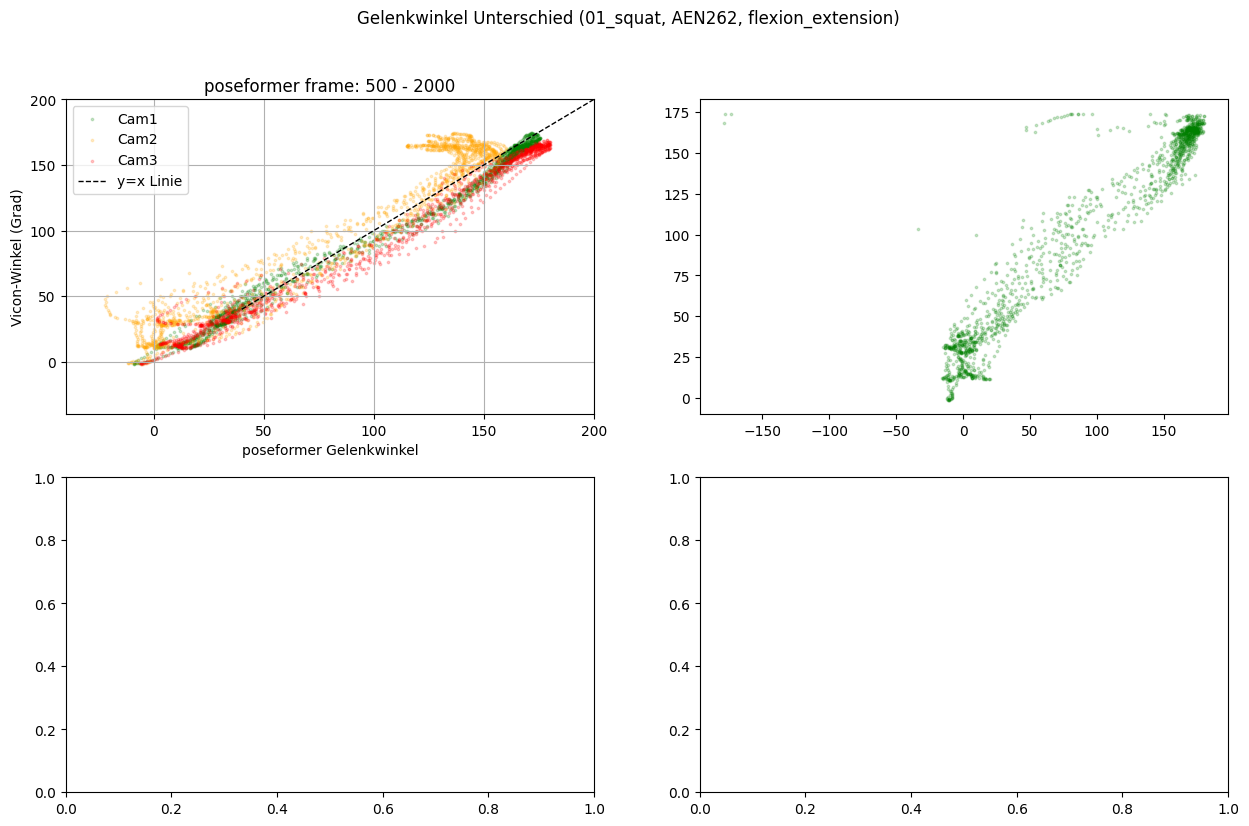

In [19]:
persons = ["AEN262", "DMN261",  "MUN261", "NSN261", "JKN261",  "MAN262"  ]  #"AEN262", "DMN261",  "MUN261", "NSN261", "JKN261",  "MAN262" 

trials_v1 = ['01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs', '13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso'] #'01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs', '13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso'
trials_v2 = ['01_squat', '02_squat', '05_torso', '06_torso', '09_ebs', '10_ebs', '13_step', '14_step', '17_tubes', '18_tubes', '21_sprint', '22_sprint'] #'01_squat', '02_squat', '05_torso', '06_torso', '09_ebs', '10_ebs', '13_step', '14_step', '17_tubes', '18_tubes', '21_sprint', '22_sprint'

#trials_v1 = ['05_squat']
#trials_v2 = ['01_squat']

person_to_trials = {
    "AEN262": trials_v2,
    "DMN261": trials_v2, 
    "MAN262": trials_v1,
    "MUN261": trials_v1,
    "NSN261": trials_v2,
    "JKN261": trials_v1,
}



for person in persons:
    for trial in person_to_trials[person]:
        # person = AEN262, trail = 01_squat 
        config = make_config(person, trial)
        print(f"Plotting for {person} and {trial}...")

        #direction = 'abduction_adduction', 'flexion_extension'
        direction = 'flexion_extension'

        #plot_angles(config, trial, person, direction)

        # plot_differences_scatter(config, trial, person, direction)
        try:
            #plot_differences_scatter_newaxis(config, trial, person, direction)
            plot_correlation(config, trial, person, direction)
            pass
        except Exception as error:
            print(f"An exception occurred in {trial} {person} {direction}", error)
            continue
        #break

    #break

        



BoxPlots

In [34]:
trial_groups_v1 = {
    'step':  ['01_step', '02_step'], 
    'squat': ['05_squat', '06_squat'], 
    'ebs':   ['09_ebs', '10_ebs'], 
    'tubes': ['13_tubes', '14_tubes'], 
    'sprint': ['17_sprint', '18_sprint'], 
    'torso': ['21_torso', '22_torso']
}
trial_groups_v2 = {
    'squat': ['01_squat', '02_squat'], 
    'torso': ['05_torso', '06_torso'], 
    'ebs': ['09_ebs', '10_ebs'], 
    'step': ['13_step', '14_step'], 
    'tubes': ['17_tubes', '18_tubes'], 
    'sprint': ['21_sprint', '22_sprint']
}

person_to_trial_groups = {
    "AEN262": trial_groups_v2,
    "DMN261": trial_groups_v2, 
    "MAN262": trial_groups_v1,
    "MUN261": trial_groups_v1,
    "NSN261": trial_groups_v2,
    "JKN261": trial_groups_v1,
}

def get_angle_differences_for_boxplot(trail_group, cam, direction, persons):
    """
    Returns a dictionary with one entry per model:
    For each model, we combine all angle differences for all persons and for the two trials within given trial_group
    e.g. for trial_group 'squat', we collect all angle differences for trials ['01_squat', '02_squat'] / ['05_squat', '06_squat']
    """
    models = ["poseformer", "mediapipe_0", "mediapipe_1", "mediapipe_2"]

    differences_combined = {
        'poseformer': [],
        'mediapipe_0': [],
        'mediapipe_1': [],
        'mediapipe_2': []
    }
    differences_combined_per_person = {}
    
    for person in persons:
        # z.B: person = 'AEN262'
        trials = person_to_trial_groups[person][trail_group]  # z.B. trails = ['01_squat', '02_squat']
        print(f"  ... person {person}, trials {trials}")
        for trial in trials:
            config = make_config(person, trial)
            for model in models:
                try:
                    vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3 = get_angles(config, model, direction)
                except Exception as error:
                    print(f"An exception occurred in plot_differences_scatter {trial} {person} {direction} {model}", error)
                    continue
            
                diff_cam1, diff_cam2, diff_cam3 = get_differences(vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3)

                if cam == 'cam1':
                    diff = diff_cam1
                elif cam == 'cam2':
                    diff = diff_cam2
                elif cam == 'cam3':
                    diff = diff_cam3
                else: 
                    raise ValueError(f"Invalid cam: {cam}")

                start_frame = 800
                end_frame = 2000

                diff_geschnitten = diff[start_frame:end_frame]
                differences_combined[model].extend(diff_geschnitten)
                if f"{model}_{person}" in differences_combined_per_person:
                    differences_combined_per_person[f"{model}_{person}"].extend(diff_geschnitten)
                else: 
                    differences_combined_per_person[f"{model}_{person}"] = list(diff_geschnitten)
    
        #break
        
    return differences_combined, differences_combined_per_person


def plot_box_plots_diff(trail_group, direction, persons):
    
    
    fig, (row1, row2, row3) = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), width_ratios=(1,2))
    fig.suptitle(f"Gelenkwinkel Unterschied ({trail_group}, {direction})")

    for row, cam in zip([row1, row2, row3], ['cam1', 'cam2', 'cam3']):
        axis_left = row[0]
        axis_right = row[1]
        print(f"Collecting angle differences for camera {cam} and trial_group {trial_group} {direction}, persons {persons}")
        differences_combined, differences_combined_per_person = get_angle_differences_for_boxplot(trial_group, cam, direction, persons)
        
        #axis_left.hlines([0], xmin=0.5, xmax=4.5, color='k', alpha=0.5, linestyles='dashed')
        axis_left.boxplot(differences_combined.values(), labels=differences_combined.keys())
        axis_left.set_title(cam)
        axis_left.set_ylim((-100, 100))
        axis_left.set_ylabel("Winkeldifferenz (Grad)")
        axis_left.grid(True, axis='y')
        for label in axis_left.get_xticklabels():
          label.set_rotation(45)
          label.set_ha('right')

        
        positions = []  # positions for boxplots: Abstände zwischen personen (+i)
        for i in range(len(persons)):
              positions.extend([i*4+i, i*4+1+i, i*4+2+i, i*4+3+i])
        axis_right.boxplot(differences_combined_per_person.values(), labels=differences_combined_per_person.keys(),
                          positions=positions)
        axis_right.set_title(cam)
        axis_right.set_ylim((-100, 100))
        axis_right.set_ylabel("Winkeldifferenz (Grad)")
        axis_right.grid(True, axis='y')
        for label in axis_right.get_xticklabels():
          label.set_rotation(45)
          label.set_ha('right')

        #break


    plt.tight_layout()
    output_dir = f"E:/Datenerhebung MA/Plots & Auswertung/shoulder_{direction}/angle_differences_boxplot/"
    os.makedirs(output_dir, exist_ok=True)
   # plt.savefig(f"{output_dir}{trial_group}_{direction}.png")
    plt.show()
    plt.close()

  ... person AEN262, trials ['01_squat', '02_squat']
  ... person DMN261, trials ['01_squat', '02_squat']
  ... person MUN261, trials ['05_squat', '06_squat']
  ... person NSN261, trials ['01_squat', '02_squat']
  ... person JKN261, trials ['05_squat', '06_squat']
  ... person MAN262, trials ['05_squat', '06_squat']
  ... person AEN262, trials ['01_squat', '02_squat']
  ... person DMN261, trials ['01_squat', '02_squat']
  ... person MUN261, trials ['05_squat', '06_squat']
  ... person NSN261, trials ['01_squat', '02_squat']
  ... person JKN261, trials ['05_squat', '06_squat']
  ... person MAN262, trials ['05_squat', '06_squat']
  ... person AEN262, trials ['01_squat', '02_squat']
  ... person DMN261, trials ['01_squat', '02_squat']
  ... person MUN261, trials ['05_squat', '06_squat']
  ... person NSN261, trials ['01_squat', '02_squat']
  ... person JKN261, trials ['05_squat', '06_squat']
  ... person MAN262, trials ['05_squat', '06_squat']


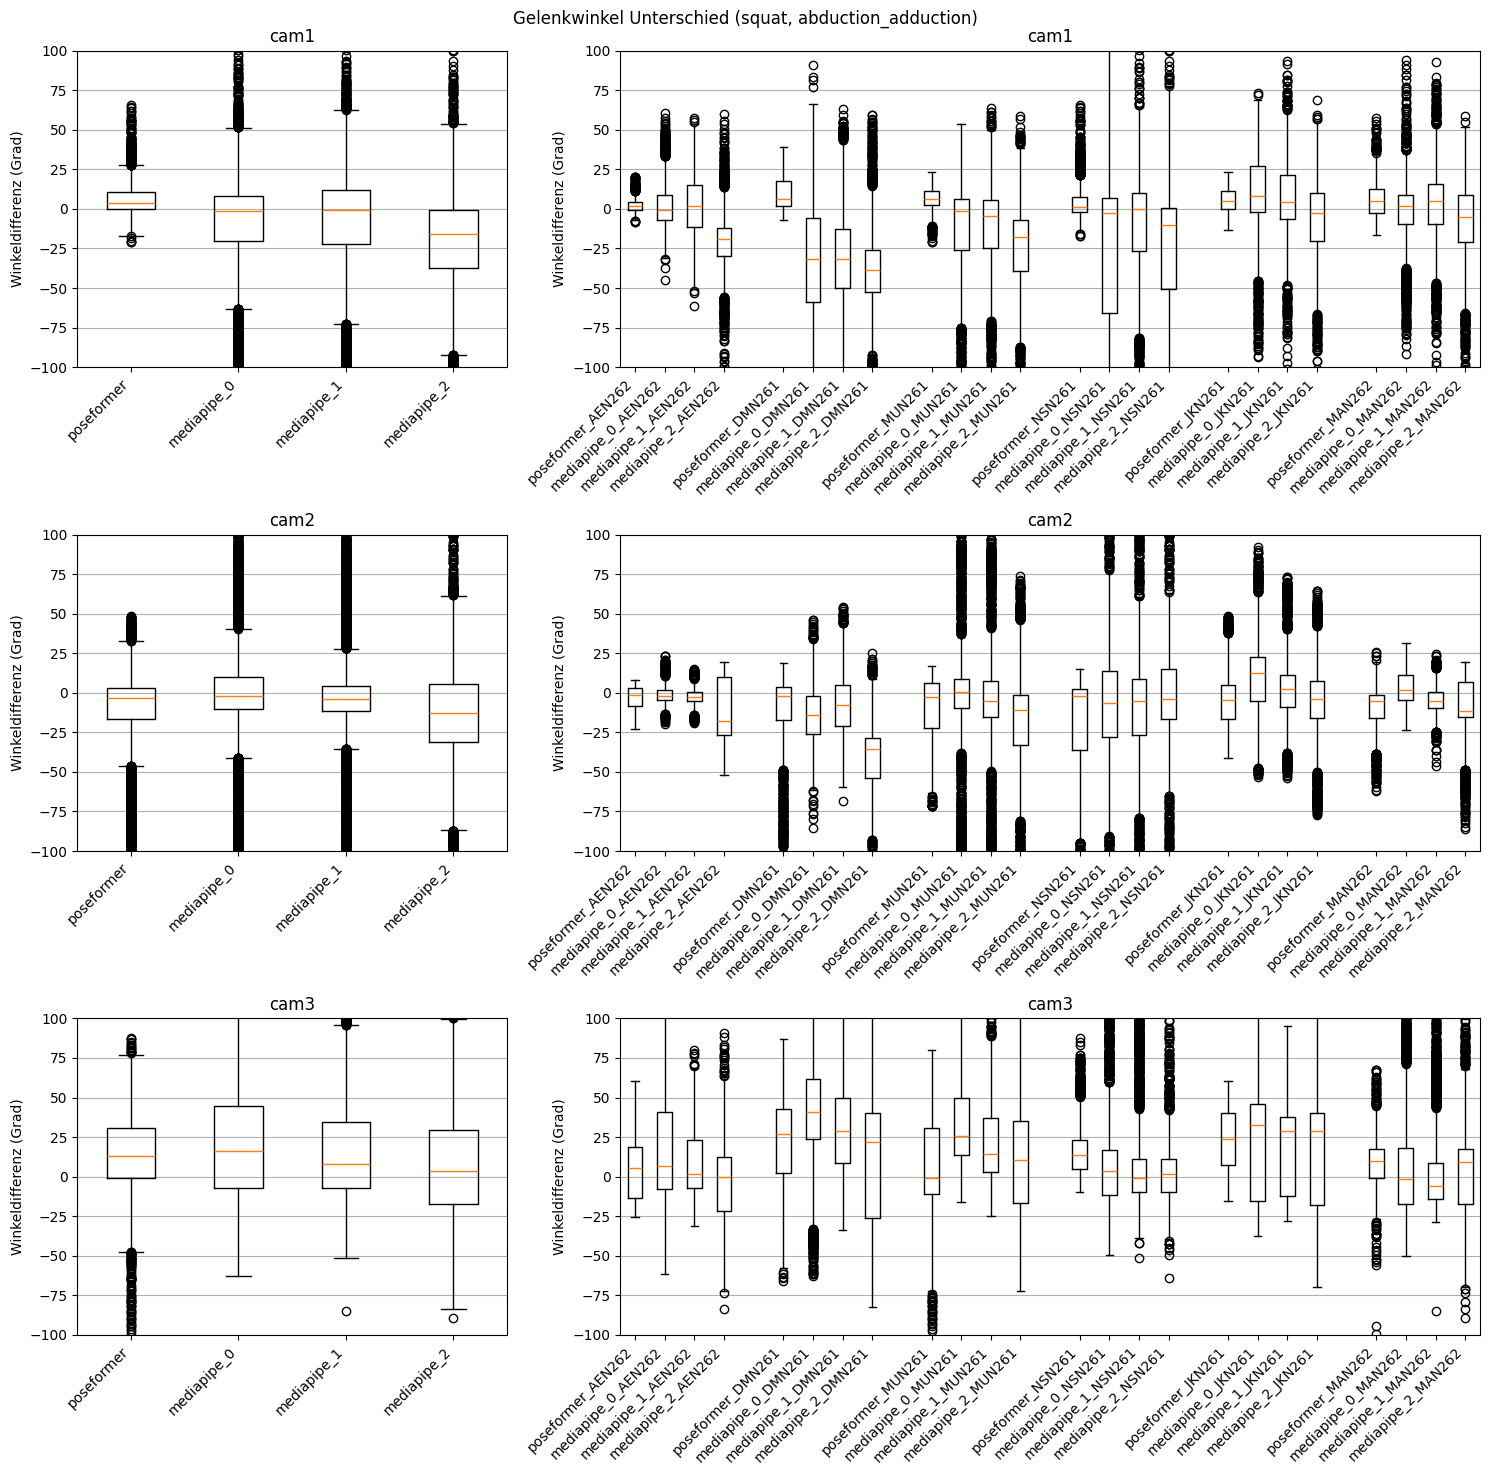

  ... person AEN262, trials ['13_step', '14_step']
  ... person DMN261, trials ['13_step', '14_step']
  ... person MUN261, trials ['01_step', '02_step']
  ... person NSN261, trials ['13_step', '14_step']
  ... person MAN262, trials ['01_step', '02_step']
  ... person JKN261, trials ['01_step', '02_step']
  ... person AEN262, trials ['13_step', '14_step']
  ... person DMN261, trials ['13_step', '14_step']
  ... person MUN261, trials ['01_step', '02_step']
  ... person NSN261, trials ['13_step', '14_step']
  ... person MAN262, trials ['01_step', '02_step']
  ... person JKN261, trials ['01_step', '02_step']
  ... person AEN262, trials ['13_step', '14_step']
  ... person DMN261, trials ['13_step', '14_step']
  ... person MUN261, trials ['01_step', '02_step']
  ... person NSN261, trials ['13_step', '14_step']
  ... person MAN262, trials ['01_step', '02_step']
  ... person JKN261, trials ['01_step', '02_step']


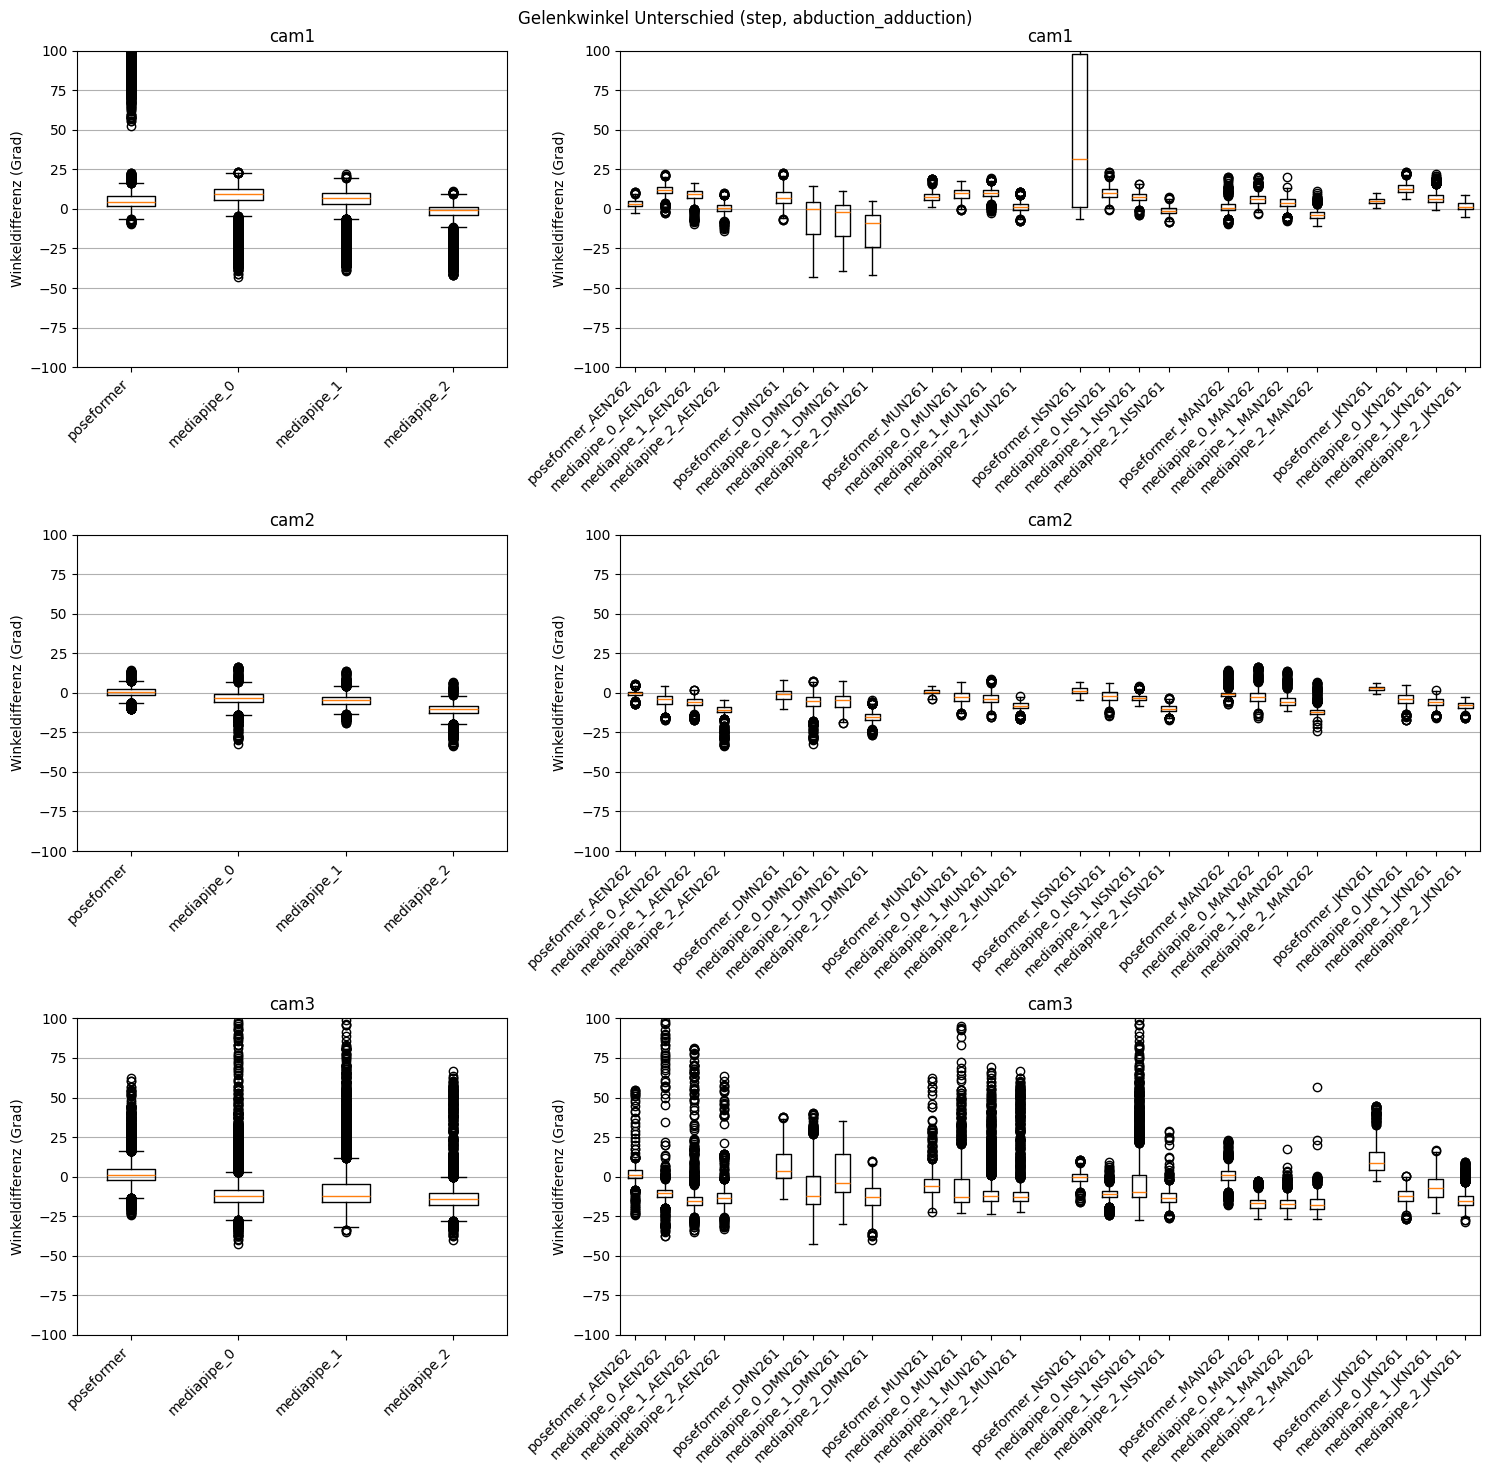

  ... person AEN262, trials ['21_sprint', '22_sprint']
  ... person DMN261, trials ['21_sprint', '22_sprint']
  ... person MUN261, trials ['17_sprint', '18_sprint']
  ... person NSN261, trials ['21_sprint', '22_sprint']
  ... person JKN261, trials ['17_sprint', '18_sprint']
  ... person MAN262, trials ['17_sprint', '18_sprint']
  ... person AEN262, trials ['21_sprint', '22_sprint']
  ... person DMN261, trials ['21_sprint', '22_sprint']
  ... person MUN261, trials ['17_sprint', '18_sprint']
  ... person NSN261, trials ['21_sprint', '22_sprint']
  ... person JKN261, trials ['17_sprint', '18_sprint']
  ... person MAN262, trials ['17_sprint', '18_sprint']
  ... person AEN262, trials ['21_sprint', '22_sprint']
  ... person DMN261, trials ['21_sprint', '22_sprint']
  ... person MUN261, trials ['17_sprint', '18_sprint']
  ... person NSN261, trials ['21_sprint', '22_sprint']
  ... person JKN261, trials ['17_sprint', '18_sprint']
  ... person MAN262, trials ['17_sprint', '18_sprint']


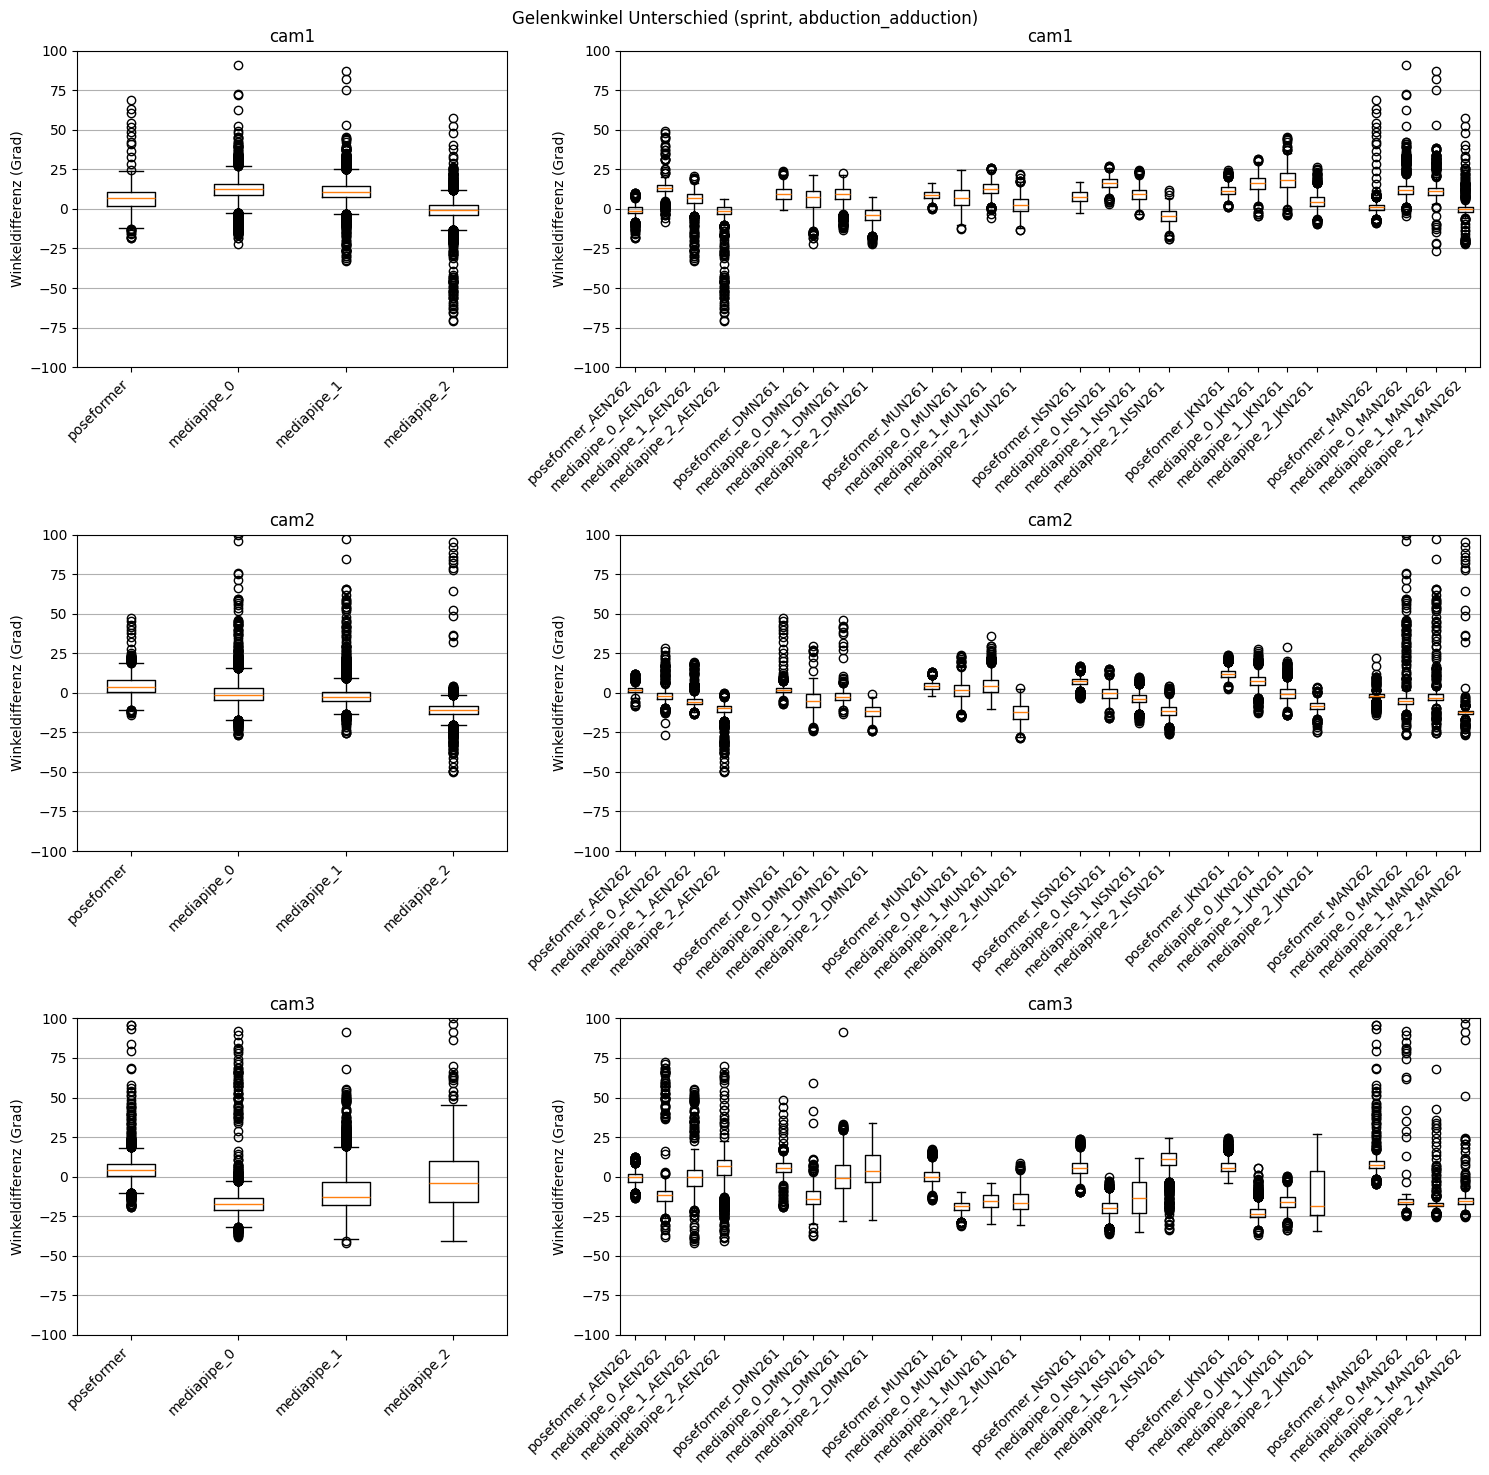

In [35]:
direction = 'abduction_adduction'

trial_group = 'squat'
plot_box_plots_diff(trial_group, direction, persons=["AEN262", "DMN261",  "MUN261", "NSN261", "JKN261", "MAN262"])

trial_group = 'step'
plot_box_plots_diff(trial_group, direction, persons=["AEN262", "DMN261",  "MUN261", "NSN261", "MAN262", "JKN261"])

trial_group = 'sprint'
plot_box_plots_diff(trial_group, direction, persons=["AEN262", "DMN261",  "MUN261", "NSN261", "JKN261", "MAN262"])


Boxplots für 2 Modelle

  ... person AEN262, trials ['17_tubes', '18_tubes']
  ... person DMN261, trials ['17_tubes', '18_tubes']
  ... person JKN261, trials ['13_tubes', '14_tubes']
  ... person MAN262, trials ['13_tubes', '14_tubes']
  ... person MUN261, trials ['13_tubes', '14_tubes']
  ... person NSN261, trials ['17_tubes', '18_tubes']
  ... person AEN262, trials ['17_tubes', '18_tubes']
  ... person DMN261, trials ['17_tubes', '18_tubes']
  ... person JKN261, trials ['13_tubes', '14_tubes']
  ... person MAN262, trials ['13_tubes', '14_tubes']
  ... person MUN261, trials ['13_tubes', '14_tubes']
  ... person NSN261, trials ['17_tubes', '18_tubes']
  ... person AEN262, trials ['17_tubes', '18_tubes']
  ... person DMN261, trials ['17_tubes', '18_tubes']
  ... person JKN261, trials ['13_tubes', '14_tubes']
  ... person MAN262, trials ['13_tubes', '14_tubes']
  ... person MUN261, trials ['13_tubes', '14_tubes']
  ... person NSN261, trials ['17_tubes', '18_tubes']
  ... person AEN262, trials ['17_tubes', '18_t

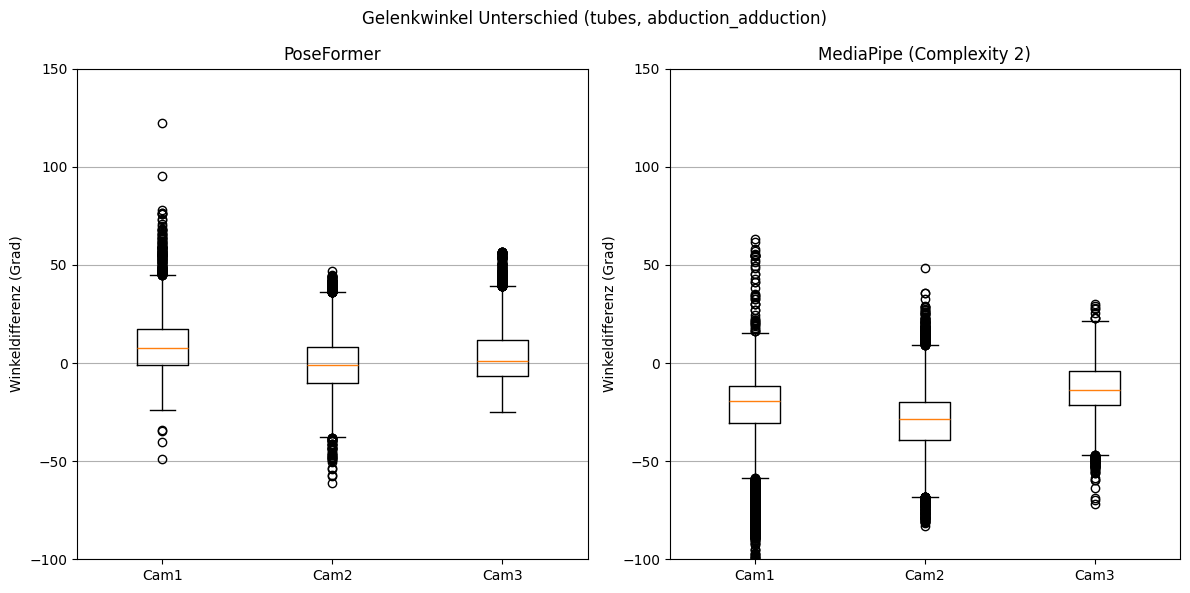

In [37]:
import matplotlib.pyplot as plt

def plot_box_plots_poseformer_vs_mediapipe(trial_group, direction, persons):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(f"Gelenkwinkel Unterschied ({trial_group}, {direction})")

    models = ["poseformer", "mediapipe_2"]  # Die beiden Modelle
    axes = [ax1, ax2]
    titles = ["PoseFormer", "MediaPipe (Complexity 2)"]

    for model, axis, title in zip(models, axes, titles):
        print(f"Collecting angle differences for {model}, trial_group {trial_group}, {direction}, persons {persons}")
        
        # Lade die Differenzdaten für alle drei Kameraperspektiven
        differences_cam1, _ = get_angle_differences_for_boxplot(trial_group, "cam1", direction, persons)
        differences_cam2, _ = get_angle_differences_for_boxplot(trial_group, "cam2", direction, persons)
        differences_cam3, _ = get_angle_differences_for_boxplot(trial_group, "cam3", direction, persons)
        
        # Extrahiere nur die Werte für das gewünschte Modell
        data = [differences_cam1[model], differences_cam2[model], differences_cam3[model]]
        labels = ["Cam1", "Cam2", "Cam3"]
        
        # Boxplot erstellen
        axis.boxplot(data, labels=labels)
        axis.set_title(title)
        axis.set_ylim((-100, 150))
        axis.set_ylabel("Winkeldifferenz (Grad)")
        axis.grid(True, axis='y')

    plt.tight_layout()
    output_dir = f"E:/Datenerhebung MA/Plots & Auswertung/shoulder_{direction}/angle_differences_boxplot/"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f"{output_dir}{trial_group}_{direction}_poseformer_vs_mediapipe.png")
    plt.show()
    plt.close()

# Beispielaufruf
trial_group = "tubes"
direction = "abduction_adduction"
persons = ["AEN262", "DMN261", "JKN261", "MAN262", "MUN261", "NSN261"]
plot_box_plots_poseformer_vs_mediapipe(trial_group, direction, persons)


## Scatterplot für alle Übungen einer Person

In [14]:
import os
import csv
import numpy as np

def calculate_and_save_angles(person, trial, model, direction, output_dir):

    # Stelle sicher, dass das Zielverzeichnis existiert
    os.makedirs(output_dir, exist_ok=True)

    # Lade die Konfiguration
    config = make_config(person, trial)

    # Versuche, die Winkel für die Kameras zu berechnen
    try:
        vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3 = get_angles(config, model, direction)

        # Berechne die Differenzen
        diff_cam1, diff_cam2, diff_cam3 = get_differences(vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3)

        # Erstelle eine CSV-Datei
        output_file = os.path.join(output_dir, f"{person}_{trial}_{model}_{direction}_angles.csv")
        with open(output_file, mode="w", newline="") as csvfile:
            csvwriter = csv.writer(csvfile)

            # Schreibe die Header-Zeile
            csvwriter.writerow([
                "Frame", 
                "Vicon_Angles", 
                "Poseformer_Angles_Cam1", "Poseformer_Angles_Cam2", "Poseformer_Angles_Cam3",
                "Cam1_Difference", "Cam2_Difference", "Cam3_Difference"
            ])

            # Füge die Winkel und Differenzen zeilenweise hinzu (nur für Frames 500 bis 2000)
            for frame, (vicon, cam1, cam2, cam3, diff1, diff2, diff3) in enumerate(
                zip(vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3, diff_cam1, diff_cam2, diff_cam3)
            ):
                if 500 <= frame <= 2000:
                    csvwriter.writerow([frame, vicon, cam1, cam2, cam3, diff1, diff2, diff3])

        print(f"Die Winkel wurden erfolgreich in {output_file} gespeichert.")

    except Exception as e:
        print(f"Ein Fehler ist aufgetreten: {e}")

In [56]:
persons = ["AEN262", "DMN261",  "MUN261", "NSN261", "JKN261",  "MAN262" ]  #"AEN262", "DMN261",  "MUN261", "NSN261", "JKN261",  "MAN262" 

trials_v1 = ['01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs', '13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso'] #'01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs', '13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso'
trials_v2 = ['01_squat', '02_squat', '05_torso', '06_torso', '09_ebs', '10_ebs', '13_step', '14_step', '17_tubes', '18_tubes', '21_sprint', '22_sprint'] #'01_squat', '02_squat', '05_torso', '06_torso', '09_ebs', '10_ebs', '13_step', '14_step', '17_tubes', '18_tubes', '21_sprint', '22_sprint'

person_to_trials = {
    "AEN262": trials_v2,
    "DMN261": trials_v2, 
    "MAN262": trials_v1,
    "MUN261": trials_v1,
    "NSN261": trials_v2,
    "JKN261": trials_v1,
}


output_dir = f"E:/Datenerhebung MA/MediaPipe/{person}/angles_csv/{direction}"
model = 'mediapipe_2'

for person in persons:
    for trial in person_to_trials[person]:
        
        
        # person = AEN262, trail = 01_squat 
        config = make_config(person, trial)
        print(f"Saving CSV for {person} and {trial}...")
        output_dir = f"E:/Datenerhebung MA/MediaPipe/{person}/angles_csv/{direction}"

        direction = 'abduction_adduction'

        try:
            calculate_and_save_angles(person, trial, model, direction, output_dir)
            pass
        except Exception as error:
            print(f"An exception occurred in {trial} {person} {direction}", error)
        continue
        #break

    #break




Saving CSV for AEN262 and 01_squat...
Die Winkel wurden erfolgreich in E:/Datenerhebung MA/MediaPipe/AEN262/angles_csv/flexion_extension\AEN262_01_squat_mediapipe_2_abduction_adduction_angles.csv gespeichert.
Saving CSV for AEN262 and 02_squat...
Die Winkel wurden erfolgreich in E:/Datenerhebung MA/MediaPipe/AEN262/angles_csv/abduction_adduction\AEN262_02_squat_mediapipe_2_abduction_adduction_angles.csv gespeichert.
Saving CSV for AEN262 and 05_torso...
Die Winkel wurden erfolgreich in E:/Datenerhebung MA/MediaPipe/AEN262/angles_csv/abduction_adduction\AEN262_05_torso_mediapipe_2_abduction_adduction_angles.csv gespeichert.
Saving CSV for AEN262 and 06_torso...
Die Winkel wurden erfolgreich in E:/Datenerhebung MA/MediaPipe/AEN262/angles_csv/abduction_adduction\AEN262_06_torso_mediapipe_2_abduction_adduction_angles.csv gespeichert.
Saving CSV for AEN262 and 09_ebs...
Die Winkel wurden erfolgreich in E:/Datenerhebung MA/MediaPipe/AEN262/angles_csv/abduction_adduction\AEN262_09_ebs_mediapi

In [69]:
import os
import pandas as pd

person = ('AEN262')
direction = 'flexion_extension'
# Pfad zu dem Ordner, der die CSV-Dateien enthält
folder_path = f"E:/Datenerhebung MA/MediaPipe/{person}/angles_csv/{direction}"

# Liste aller Dateien im Ordner mit der Endung '.csv'
all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')  and f != "combined_data.csv"]

# Initialisiere einen leeren DataFrame für die kombinierten Daten
combined_data = pd.DataFrame()

# Iteriere über alle Dateien und füge sie zum kombinierten DataFrame hinzu
for file in all_files:
    file_path = os.path.join(folder_path, file)
    try:
        # Lade die Datei
        df = pd.read_csv(file_path)
        
        # Optionale Spalte hinzufügen, um die Quelle zu markieren
        df['Source_File'] = file
        
        # Kombiniere die Daten
        combined_data = pd.concat([combined_data, df], ignore_index=True)
    except Exception as e:
        print(f"Fehler beim Verarbeiten der Datei {file}: {e}")

# Speichere die kombinierten Daten in einer neuen CSV-Datei
output_file = os.path.join(folder_path, f"E:/Datenerhebung MA/MediaPipe/{person}/angles_csv/{direction}/all_trials_angles.csv")
combined_data.to_csv(output_file, index=False)

print(f"Alle Dateien wurden erfolgreich kombiniert und gespeichert in: {output_file}")

Alle Dateien wurden erfolgreich kombiniert und gespeichert in: E:/Datenerhebung MA/MediaPipe/AEN262/angles_csv/flexion_extension/all_trials_angles.csv


Der Scatterplot wurde als PNG unter 'E:/Datenerhebung MA/Plots & Auswertung/shoulder_abduction_adduction/kalibrationsfiles/scatterplot_NSN261_mediapipe_2.png' gespeichert.


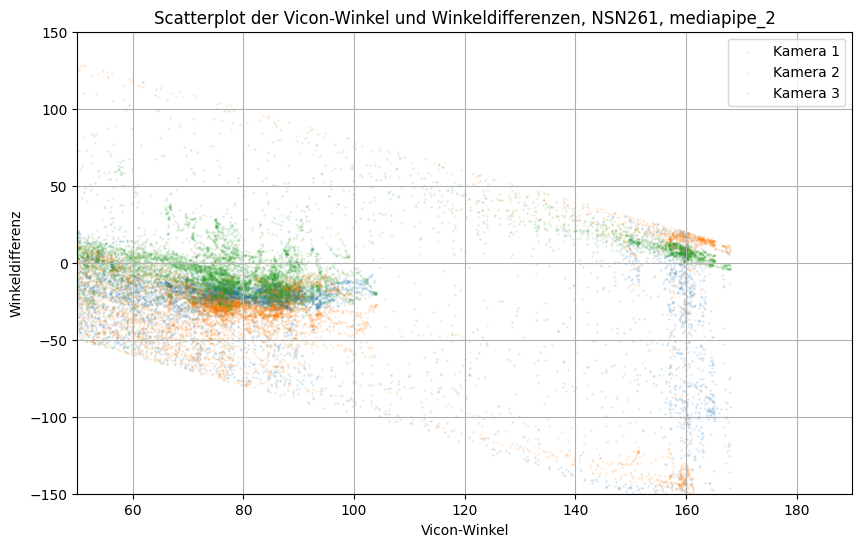

In [91]:
import pandas as pd
import matplotlib.pyplot as plt

person = 'NSN261'
model = 'mediapipe_2'
direction = 'abduction_adduction'
# CSV-Datei laden
file_path = f"E:/Datenerhebung MA/MediaPipe/{person}/angles_csv/{direction}/all_trials_angles.csv"
df = pd.read_csv(file_path)

# Scatterplot erstellen
plt.figure(figsize=(10, 6))

# Kamera 1
plt.scatter(df['Vicon_Angles'], df['Cam1_Difference'], label='Kamera 1', alpha=0.1, s=1)
# Kamera 2
plt.scatter(df['Vicon_Angles'], df['Cam2_Difference'], label='Kamera 2', alpha=0.1, s=1)
# Kamera 3
plt.scatter(df['Vicon_Angles'], df['Cam3_Difference'], label='Kamera 3', alpha=0.1, s=1)


# Achsen anpassen (fixieren)
plt.xlim([50, 190])  # Puffer um die Daten
plt.ylim([-150, 150])  # Beispielbereich für die Winkeldifferenzen

# Plot anpassen
plt.xlabel('Vicon-Winkel')
plt.ylabel('Winkeldifferenz')
plt.title(f'Scatterplot der Vicon-Winkel und Winkeldifferenzen, {person}, {model}')
plt.legend()
plt.grid(True)

# Plot als PNG speichern
output_path = f"E:/Datenerhebung MA/Plots & Auswertung/shoulder_{direction}/kalibrationsfiles/scatterplot_{person}_{model}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Plot anzeigen
#plt.show()

print(f"Der Scatterplot wurde als PNG unter '{output_path}' gespeichert.")